# Figure 02

A figure showing how the solitary wave of mutation load travels in the fitness space over time.
We show the a normalized panel and the profile. Additionally we show a wave under strong selection with its profile.
the last panel showes the predicted mean mutation load over time under different conditions of $U$ (2x) and $s$ (5x).

## Import libraries

In [1]:
import glob
import os
import pickle
import re
import sys
import time

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.stats import poisson

from calc_coalescence_densities import *
from travelling_wave_approach import *

print(imported())

True


## Parameters and functions

In [2]:
seed = 42
N, _, U = 5000, 4e-4, 0.006
U2 = 0.004
print(f"phi={phi(N, _, U)}")
s_list = [0, 1e-4, 4e-4, 2e-3, 4.1e-3]

phi=6.12e-07


In [3]:
def add_wave_to_ax(ax, wave, ylim=None, title=None, cbar_pad=0, cpad=0, cbar=True):
    my_map = np.log10(wave.T+1)
    ax = sns.heatmap(my_map, ax=ax, cmap="inferno", mask=my_map==0, cbar=cbar)
    ax.invert_yaxis()
    ax.set_xlabel("Time (gen)")
    ax.set_ylabel("Mutation load")
    # xticks
    xticks = np.arange(0, my_map.shape[1]+1, 2000)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation = 0)
    
    # yticks
    yticks = np.arange(0, my_map.shape[0]+1, 10)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)

    if cbar:
        cbar = ax.collections[0].colorbar
        #cbar = plt.colorbar(ax=ax, pad=cpad)
        cbar.set_label('Number of individuals',
                       labelpad=cbar_pad,
                       size=8
                      )  # Adjust the labelpad value as needed
        cbar_ticks = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000])
        cbar.set_ticks(np.log10(cbar_ticks + 1))
        cbar.set_ticklabels(cbar_ticks)
    
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(1)

    if not ylim is None:
        ax.set_ylim(*ylim)

    if not title is None:
        ax.set_title(title)

    return

In [4]:
def add_profile_to_ax(ax, data_frame):
    plot = sns.pointplot(
        data_frame,
        errorbar=("pi", 50),
        linewidth=0.7,
        err_kws=dict(linewidth=0.7, alpha=0.7),
        orient="h",
        ax=ax,
        color="black"
    )

    return

In [5]:
def do_despine(ax, spines=["right", "top", "left", "bottom"]):
    for pos in spines:
        ax.spines[pos].set_visible(False)

    return

## Data and processing

In [6]:
thrown_stones = []

for s in s_list:
    print(f"phi={phi(N, s, U)}")
    thrown_stone = throw_a_stone(
        N,
        s, 
        U,
        options={"mode": "velocity_and_distribution",
                 "burnin": 0,
                 "burnin_fitter": 2_000,
                 "generations": 12_000,
                 "thinning": 1,
                 "return_wave": True,
                 "return_fitter": True,
                 "return_sim": True},
        seed = seed
    )

    thrown_stones.append(thrown_stone)

phi=0


 calc wave (1/1): 100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 10208.61it/s]


phi=4.38e-27


 calc wave (1/1): 100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 10213.17it/s]


phi=6.12e-07


 calc wave (1/1): 100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 10596.89it/s]


phi=0.498


 calc wave (1/1): 100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 11537.96it/s]


phi=4.74


 calc wave (1/1): 100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:00<00:00, 12232.52it/s]


In [7]:
# extract the waves
waves = []

for stone in thrown_stones:
    (velocity, distribution), wave, fitter, sim = stone
    print(velocity)
    waves.append(wave)

0.8497533752309337
0.6803027945570255
0.43219828964158086
0.083924457780645
0.011550117487101087


In [8]:
# create normalized waves
waves_norm = []
for stone in thrown_stones:
    (velocity, distribution), wave, fitter, sim = stone
    print(velocity)
    mean_fitness_pred = fitter.predict(np.arange(sim.shape[0]).reshape(-1, 1))
    sim_norm = sim - mean_fitness_pred[:, np.newaxis]
    sim_norm = sim_norm - sim_norm.min()

    bin_edges = np.arange(-0.5, np.ceil(sim.max()) + 1.5, 1)
    simhk_t = np.zeros((sim_norm.shape[0], len(bin_edges)-1))

    for generation_index in tqdm.trange(
        simhk_t.shape[0],
        desc=f" calc wave",
    ):
        simhk_t_i, _ = np.histogram(sim_norm[generation_index, :], bins=bin_edges)
        simhk_t[generation_index, :] = simhk_t_i
    
    
    waves_norm.append(simhk_t)

0.8497533752309337


 calc wave: 100%|██████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 10125.78it/s]


0.6803027945570255


 calc wave: 100%|██████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 10205.96it/s]


0.43219828964158086


 calc wave: 100%|███████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 9604.17it/s]


0.083924457780645


 calc wave: 100%|██████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 11540.46it/s]


0.011550117487101087


 calc wave: 100%|██████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:00<00:00, 12680.39it/s]


In [9]:
# prepare the second mutation rate predictions
prediction_times = np.arange(0, 12_000, 100)
predicted_means_2 = []
for s in s_list:
    print(f"phi={phi(N, s, U2)}")
    thrown_stone = throw_a_stone(
        N,
        s, 
        U2,
        options={"mode": "velocity_and_distribution",
                 "burnin": 0,
                 "burnin_fitter": 2_000,
                 "generations": 12_000,
                 "thinning": 1,
                 "return_wave": True,
                 "return_fitter": True,
                 "return_sim": True},
        seed = seed + 42
    )

    (velocity, distribution), wave, fitter, sim = thrown_stone
    time.sleep(0.1)
    print(velocity)
    mean_fitness_pred = fitter.predict(prediction_times.reshape(-1, 1))
    predicted_means_2.append(mean_fitness_pred)
predicted_means_2 = pd.DataFrame(np.array(predicted_means_2).T, index=prediction_times)

phi=0


 calc wave (1/1): 100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 10327.84it/s]


0.949835866264862
phi=2.12e-18


 calc wave (1/1): 100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 10637.49it/s]


0.7036507478265076
phi=9.08e-05


 calc wave (1/1): 100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 11276.40it/s]


0.4262462284140616
phi=1.35


 calc wave (1/1): 100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:00<00:00, 12261.58it/s]


0.09109595946375931
phi=7.73


 calc wave (1/1): 100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:00<00:00, 13332.86it/s]


-0.0030599887178999027


In [10]:
predicted_means = []
for stone in thrown_stones:
    (velocity, distribution), wave, fitter, sim = stone
    print(velocity)
    mean_fitness_pred = fitter.predict(prediction_times.reshape(-1, 1))
    predicted_means.append(mean_fitness_pred)
predicted_means = pd.DataFrame(np.array(predicted_means).T, index=prediction_times)

0.8497533752309337
0.6803027945570255
0.43219828964158086
0.083924457780645
0.011550117487101087


In [11]:
if True:
    a = predicted_means.reset_index(names="time").melt(id_vars="time", var_name="sel_id", value_name="mutload")
    a["U"] = U
    b = predicted_means_2.reset_index(names="time").melt(id_vars="time", var_name="sel_id", value_name="mutload")
    b["U"] = U2

In [12]:
if False:
    predicted_means = pd.concat([a, b])
    predicted_means["freq"] = predicted_means["mutload"] / (12_000 * predicted_means["U"])
    predicted_means["id"] = predicted_means["sel_id"].apply(str) + "_" + predicted_means["U"].apply(str)

    predicted_means.head()

In [13]:
a["sel"] = a["sel_id"].apply(lambda x: N * s_list[x])

In [14]:
b["sel"] = b["sel_id"].apply(lambda x: N * s_list[x])

## Visualisation

In [15]:
old_style = False
if old_style:
    sns.set(style="ticks", context="paper", font_scale=1)
    
    fig = plt.figure(figsize=(7.5, 5.5))
    gs = fig.add_gridspec(nrows=2, ncols=5)
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[0, 4])
    ax4 = fig.add_subplot(gs[1, 0:2])
    ax5 = fig.add_subplot(gs[1, 2:4])
    ax6 = fig.add_subplot(gs[1, 4])
    
    #ax = np.array([[ax1, ax2, ax3], [ax4, ax5, ax6]])
    
    # waves
    add_wave_to_ax(
        ax1, waves[2], title="Traveling fitness wave", cbar_pad=-49, cbar=False
    )
    add_wave_to_ax(ax2, waves_norm[2], title="Normalized fitness wave", cbar_pad=-44)
    ax2.set_xlim(2_000, None)
    add_wave_to_ax(
        ax5,
        waves[4],
        ylim=[0, 23],
        #yticks=np.arange(0, 100, 10),
        title="Fitness at $\mu/s$ balance",
        cbar_pad=-44,
    )
    ax5.set_xlim(2_000, None)
    ax5.set_yticks([0, 10, 20])
    ax5.set_yticklabels([0, 10, 20])
    
    # profiles
    add_profile_to_ax(ax3, (pd.DataFrame(waves_norm[2][2000:, :]) / N).iloc[:, 0:23])
    ax3.invert_yaxis()
    ax3.set_yticks(np.arange(0, 50, 10))
    ax3.set_yticklabels(np.arange(0, 50, 10))
    ax3.set_ylim(None, 46)
    ax3.set_xlabel("Frequency")
    ax3.set_ylabel("Mutation load")
    ax3.set_title("Wave profile")
    
    # theoretical result
    k_nd = np.arange(12)
    profile_nd = np.array([hk(_, U, s) for _ in k_nd])
    ax6.plot(profile_nd, k_nd, color="purple", label="$h_k$ ($\Theta$)")
    add_profile_to_ax(ax6, pd.DataFrame(waves[4][2000:, :]) / N)
    ax6.invert_yaxis()
    ax6.legend(loc="best")
    ax6.set_ylim(None, 23)
    ax6.set_yticks([0, 10, 20])
    ax6.set_yticklabels([0, 10, 20])
    ax6.set_xlabel("Frequency")
    ax6.set_ylabel("Mutation load")
    ax6.set_title("Wave profile")
    
    # mean fitness prediction
    plt.axes(ax4)
    lines = []
    lines2 = []
    for colid, col in enumerate(predicted_means.columns):
        (l_,) = plt.plot(
            predicted_means.index,
            predicted_means[col],
            linewidth=3,
            linestyle="-",
            color=sns.color_palette("dark:salmon_r")[colid],
            label=f"s = {s_list[colid]}",
        )
        lines.append(l_)
    for colid, col in enumerate(predicted_means_2.columns):
        (l_,) = plt.plot(
            predicted_means_2.index,
            predicted_means_2[col],
            linewidth=1.2,
            linestyle="dashed",
            color=sns.color_palette("dark:salmon_r")[colid],
            label=f"s = {s_list[colid]}",
        )
        lines2.append(l_)
    legend_1 = plt.legend(
        lines,
        [f"$Ns = {N * s_list[colid]}$" for colid in range(5)],
        loc="upper left",
        title=f"Selection\nstrength",
        framealpha=0.95,
        fontsize=8
    )
    plt.legend(
        [lines[-1], lines2[-1]],
        [f"$U_d = {U}$", f"$U_d={U2}$"],
        loc="upper right",
        #bbox_to_anchor=(0.45, 1),
        title=f"Mutation\nrate",
        framealpha=0.95,
        fontsize=8
    )
    plt.gca().add_artist(legend_1)
    ax4.set_title("Mean fitness prediction")
    ax4.set_xlabel("Time in generations")
    ax4.set_ylabel("Mutation load")
    ax4.set_ylim(0, 46)
    ax4.set_xlim(0, 12_000)
    # ax4.set_aspect(12_000 / 55)
    ax4.patch.set_linewidth(0.7)
    plt.yticks(ticks=[0, 10, 20, 30, 40], rotation=90)
    
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    labels = ["A", "B", "C", "D", "E", "F"]
    for ax_, label_ in zip(axes, labels):
        ax_.text(
            -0.1, 1.15, label_,
            transform=ax_.transAxes,
            fontsize=14,
            va='top',
            ha='right'
        )
    
    
    for ax_ in [ax2, ax3, ax5, ax6]:
        ax_.set_ylabel(None)
        #ax_.set_yticklabels([])
    
    for ax_ in [ax1, ax2, ax3]:
        ax_.set_xlabel(None)
    
    
    plt.tight_layout(h_pad=1.08, w_pad=-0.25)
    
    plt.show()
    plt.close()

In [27]:
def add_wave_to_ax(ax, wave, ylim=None, title=None, cbar_pad=0, cpad=0, cbar=True, cbar_ax=None, ylabel=True):
    my_map = np.log10(wave.T+1)
    ax = sns.heatmap(my_map, ax=ax, cmap="inferno", mask=my_map==0, cbar=cbar, cbar_ax=cbar_ax if cbar else None)
    ax.invert_yaxis()
    ax.set_xlabel("Time (gen)")
    if ylabel:
        ax.set_ylabel("Mutation load")
    # xticks
    xticks = np.arange(0, my_map.shape[1], 3000)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation = 0)
    
    # yticks
    yticks = np.arange(0, my_map.shape[0]+1, 10)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)

    if cbar:
        cbar = ax.collections[0].colorbar
        #cbar = plt.colorbar(ax=ax, pad=cpad)
        cbar.set_label('Number of individuals',
                       labelpad=cbar_pad,
                       size=9.4
                      )  # Adjust the labelpad value as needed
        cbar_ticks = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000])
        cbar.set_ticks(np.log10(cbar_ticks + 1))
        cbar.set_ticklabels(cbar_ticks)
    
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(1)

    if not ylim is None:
        ax.set_ylim(*ylim)

    if not title is None:
        ax.set_title(title)

    return

In [28]:
def add_profile_to_ax(ax, data_frame=None, make_legend=False):
    data_frame = data_frame.melt(var_name="mutload", value_name="freq")
    data_frame["color"] = make_legend
    
    ax = sns.pointplot(
        data=data_frame,
        x="freq",
        y="mutload",
        hue="color" if make_legend else None,
        errorbar=("pi", 50),
        linewidth=0.7,
        err_kws=dict(linewidth=0.7, alpha=0.7),
        orient="h",
        ax=ax,
        color="black" if not make_legend else None,
        palette=["black"] if make_legend else None
    )

    if make_legend:
        ax.legend(title=None)

    return ax

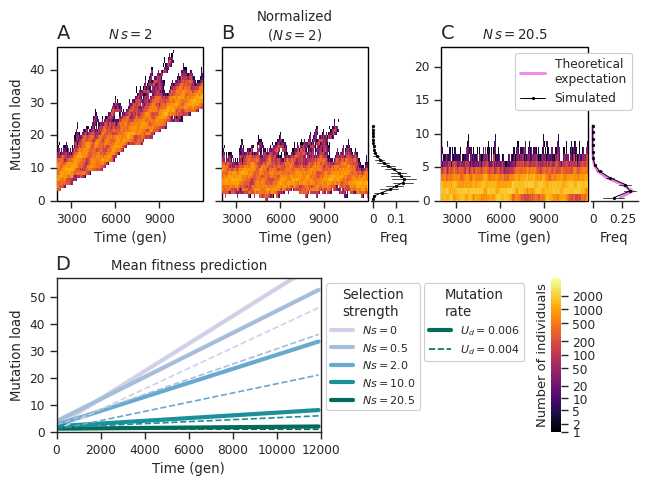

In [36]:
sns.set(style="ticks", context="paper", font_scale=1.0)

#figsize = (9.5, 5.5)
figsize = 7.5, 5
fig = plt.figure(figsize=figsize, constrained_layout=False)

# panels
gs = fig.add_gridspec(nrows=2, ncols=11, wspace=.75, hspace=0.5)

gs1 = gs[0, :4].subgridspec(1, 4, wspace=0.05)
gs2 = gs[0, 3:7].subgridspec(1, 4, wspace=0.05)
gs3 = gs[0, 7:11].subgridspec(1, 4, wspace=0.05)

gs4 = gs[1, :11].subgridspec(1, 2)

gs_cbar = gs[1, 9].subgridspec(1, 3)

ax1 = fig.add_subplot(gs1[0, 0:3])
ax2 = fig.add_subplot(gs2[0, 0:3])
ax2_1 = fig.add_subplot(gs2[0, 3])
ax3 = fig.add_subplot(gs3[0, 0:3])
ax3_1 = fig.add_subplot(gs3[0, 3])

ax4 = fig.add_subplot(gs4[0, 0])

ax_cbar = fig.add_subplot(gs_cbar[0, 0])


# waves
add_wave_to_ax(
    ax1, waves[2], title="$N \, s = 2$", cbar_pad=-48, cbar=True, cbar_ax=ax_cbar
)
ax1.set_xlim(2_000, None)
add_wave_to_ax(ax2, waves_norm[2], title="Normalized\n$(N \, s = 2)$", cbar=False, 
    ylabel=False)
ax2.set_xlim(2_000, None)
ax2.set_yticklabels([])
add_wave_to_ax(
    ax3,
    waves[4],
    ylim=[0, 23],
    #yticks=np.arange(0, 100, 10),
    title="$N \, s = 20.5$",
    cbar=False,
    ylabel=False
)
plt.axes(ax3)
plt.yticks(ticks=np.arange(0, 20+1, 5), labels=np.arange(0, 20+1, 5), rotation=0)
ax3.set_xlim(2_000, None)
#ax3.set_yticks([0, 10, 20])
#ax3.set_yticklabels([0, 10, 20])

# profiles
ax2_1 = add_profile_to_ax(ax2_1, (pd.DataFrame(waves_norm[2][2000:, :]) / N).iloc[:, 0:23])
ax2_1.invert_yaxis()
ax2_1.set_yticks([])
ax2_1.set_ylim(None, 46)
ax2_1.set_xlabel("Freq")
do_despine(ax2_1, spines=["top", "right", "left"])
ax2_1.set_xticks([0, 0.1])
ax2_1.set_xticklabels(["0", "0.1"])
ax2_1.set_ylabel(None)
#ax2_1.set_title("Wave profile")

# theoretical result
k_nd = np.arange(12)
profile_nd = np.array([hk(_, U, s) for _ in k_nd])
ax3_1.plot(profile_nd, k_nd, color="violet", label="Theoretical\nexpectation", linewidth=2)
ax3_1 = add_profile_to_ax(ax3_1, pd.DataFrame(waves[4][2000:, :]) / N, make_legend="Simulated")
ax3_1.legend().get_frame().set_alpha(1.0)
ax3_1.invert_yaxis()
#ax3_1.legend(loc="best")
ax3_1.set_ylim(None, 23)
ax3_1.set_yticks([])
ax3_1.set_xlabel("Freq")
do_despine(ax3_1, spines=["top", "right", "left"])
ax3_1.set_xticks([0, 0.25])
ax3_1.set_xticklabels(["0", "0.25"])
ax3_1.set_ylabel(None)
#ax3_1.set_title("Wave profile")

# mean fitness prediction
plt.axes(ax4)
lines = []
lines2 = []
#my_color_palette = sns.color_palette("flare")
#my_color_palette = ['#f6eff7','#bdc9e1','#67a9cf','#1c9099','#016c59']
my_color_palette = """
#f6eff7
#d0d1e6
#a6bddb
#67a9cf
#1c9099
#016c59
""".split()[1:]

for colid, col in enumerate(predicted_means.columns):
    (l_,) = plt.plot(
        predicted_means.index,
        predicted_means[col],
        linewidth=3,
        linestyle="-",
        color=my_color_palette[colid],
        label=f"s = {s_list[colid]}",
    )
    lines.append(l_)
for colid, col in enumerate(predicted_means_2.columns):
    (l_,) = plt.plot(
        predicted_means_2.index,
        predicted_means_2[col],
        linewidth=1.2,
        linestyle="dashed",
        color=my_color_palette[colid],
        label=f"s = {s_list[colid]}",
    )
    lines2.append(l_)
legend_1 = plt.legend(
    lines,
    [f"$Ns = {N * s_list[colid]}$" for colid in range(5)],
    #loc="upper left",
    bbox_to_anchor=(1, 1),
    title=f"Selection\nstrength",
    framealpha=0.95,
    fontsize=8,
)
plt.legend(
    [lines[-1], lines2[-1]],
    [f"$U_d = {U}$", f"$U_d={U2}$"],
    loc="upper left",
    #bbox_to_anchor=(1.32, 1),
    bbox_to_anchor=(1.37, 1),
    title=f"Mutation\nrate",
    framealpha=0.95,
    fontsize=8
)
plt.gca().add_artist(legend_1)
ax4.set_title("Mean fitness prediction")
ax4.set_xlabel("Time (gen)")
ax4.set_ylabel("Mutation load")
ax4.set_ylim(0, 57)
ax4.set_xlim(0, 12_000)
# ax4.set_aspect(12_000 / 55)
ax4.patch.set_linewidth(0.7)
plt.yticks(ticks=np.arange(0, 60, 10), rotation=0)
#sns.move_legend(ax4, "upper left", bbox_to_anchor=(1, 1))


if False:
    for ax_ in [ax2, ax3, ax5, ax6]:
        ax_.set_ylabel(None)
        #ax_.set_yticklabels([])
    
    for ax_ in [ax1, ax2, ax3]:
        ax_.set_xlabel(None)


axes = [ax1, ax2, ax3, ax4]  #, ax5, ax6]
labels = ["A", "B", "C", "D", "E", "F"]
for i, (ax_, label_) in enumerate(zip(axes, labels)):
    ax_.text(
        #-0.1, 1.15,
        0.09 if i != 3 else 0.051,
        1.15,
        label_,
        transform=ax_.transAxes,
        fontsize=14,
        va='top',
        ha='right'
    )



# plt.tight_layout()

plt.show()
plt.close()

## Save data and figure

In [37]:
# get the highest version of the figure and name filename one higher
version = max([int(re.search(r'v(\d+)', filename).group(1)) for filename in glob.glob("figure2_v*.png")]) + 1
assert version < 100, "Biggest version is 3 digits, you need a new string formatter"
new_filename = f"figure2_v{version:02d}.png"

print(f"New filename: '{new_filename}'")

plt.figure(fig)
fig.savefig(new_filename, dpi=600)
plt.close()

New filename: 'figure2_v19.png'
